In [9]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import (
    compare_model_accuracies,
    logo_cv_confidence_interval,
)

from charts import (
    model_swarmplot,
)

plt.rcParams["svg.hashsalt"] = "my_deterministic_salt"

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

| Architecture | Simple1d | Simple1dEmbedding | Simple2d | Simple2dEmbedding | ResNet50 | ResNet50Embedding |
| ------------ | ------------: | ------------: | ------------: | ------------: | ------------: | ------------: |
| alpha | 0.997±0.004 | 0.953±0.043 | 1.000±0.000 | 0.938±0.073 | 0.973±0.029 | 0.990±0.011 |
| amd64 | 0.981±0.011 | 0.987±0.020 | 0.943±0.016 | 0.991±0.022 | 0.952±0.014 | 0.993±0.013 |
| arm64 | 0.713±0.291 | 0.730±0.259 | 0.413±0.098 | 0.545±0.297 | 0.251±0.096 | 0.562±0.316 |
| armel | 1.000±0.000 | 0.987±0.022 | 1.000±0.000 | 0.984±0.031 | 1.000±0.000 | 0.994±0.004 |
| armhf | 0.939±0.038 | 0.985±0.011 | 0.982±0.008 | 0.980±0.018 | 0.972±0.004 | 0.963±0.016 |
| hppa | 0.305±0.243 | 0.697±0.309 | 0.125±0.038 | 0.666±0.279 | 0.521±0.195 | 0.306±0.213 |
| i386 | 0.969±0.028 | 0.998±0.003 | 0.980±0.014 | 0.997±0.005 | 0.970±0.013 | 0.992±0.005 |
| ia64 | 0.414±0.428 | 0.884±0.058 | 0.098±0.236 | 0.611±0.414 | 0.482±0.308 | 0.372±0.369 |
| m68k | 0.008±0.015 | 0.096

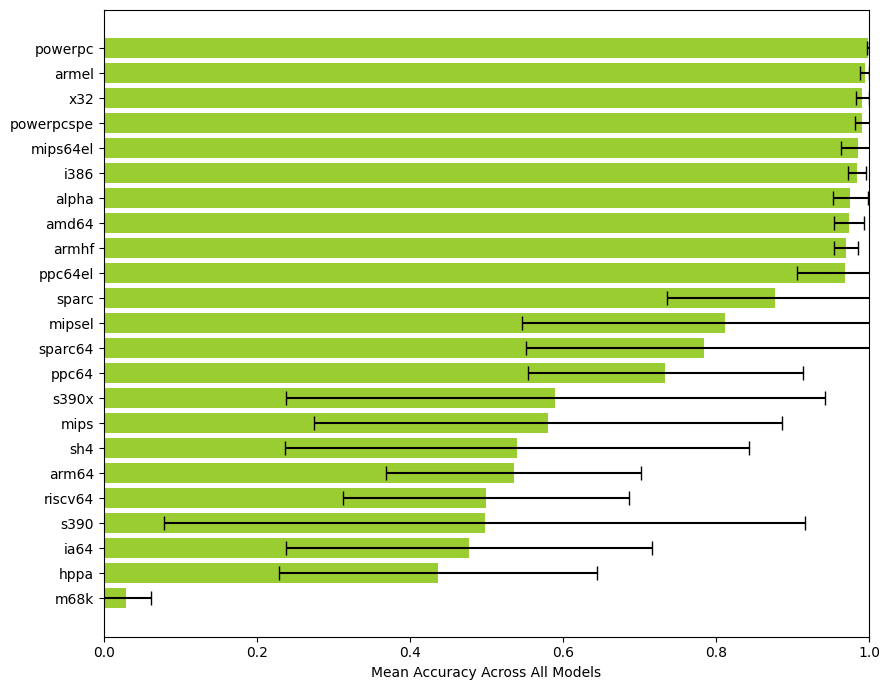

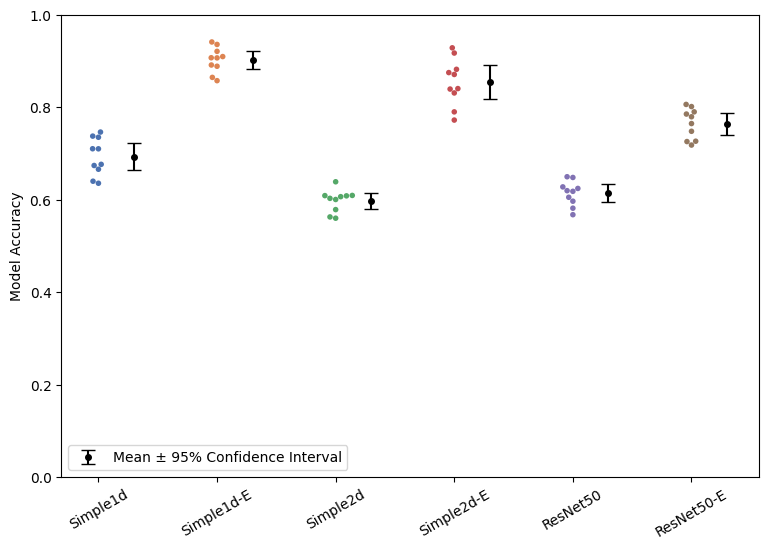

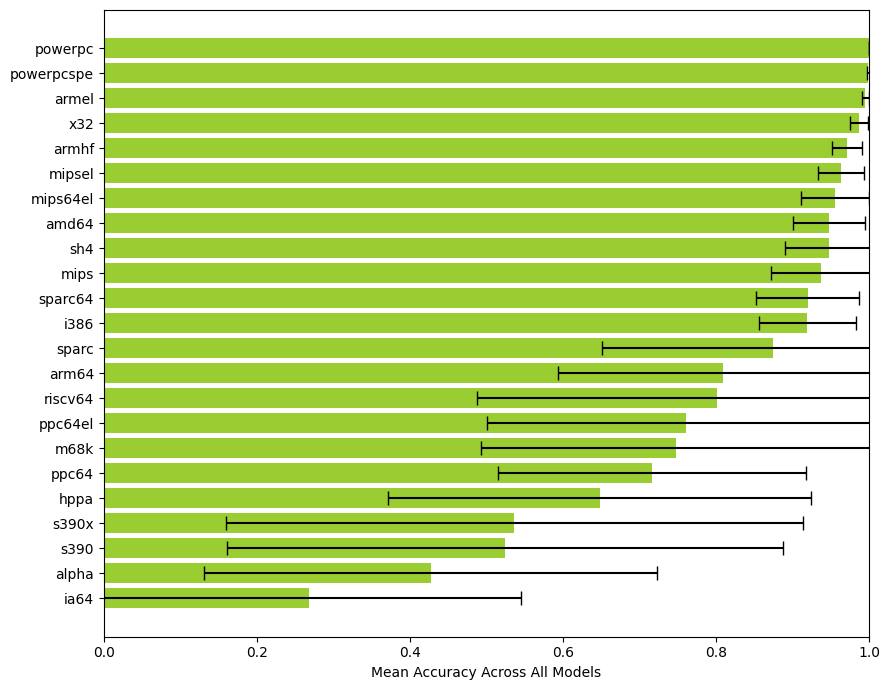

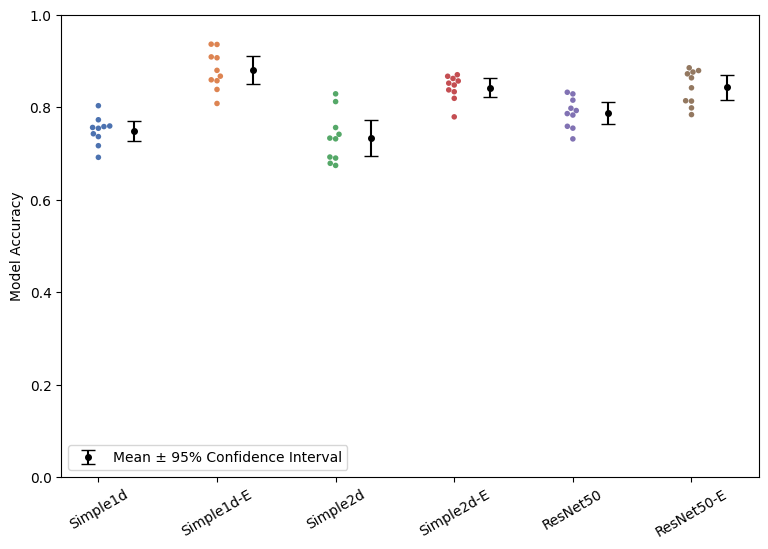

In [ ]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "LOGO-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    # Create a dictionary to store results for each model
    model_results = {}
    model_overall_results = {}
    violin_plot_data = {}

    # Get all unique architectures across all models
    all_architectures = set()

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        model_run_accuracies = df[df["Name"] == "overall_metrics"][
            "overall_accuracy"
        ].values

        # Filter out rows with Name "overall_metrics"
        df_filtered = df[df["Name"] != "overall_metrics"]

        # Group by the seed column and create a list of accuracies
        accuracies_per_run_per_fold_lists = (
            df_filtered.groupby("validator.seed")["test_accuracy_chunk"]
            .apply(list)
            .tolist()
        )

        # Group by the seed column and create a list of dataset sizes
        fold_sample_counts = (
            df_filtered.groupby("validator.seed")["test_dataset_size"]
            .apply(list)
            .tolist()
        )

        # Get overall metrics
        overall_mean, overall_conf_95, _, _ = logo_cv_confidence_interval(
            all_run_fold_accuracies=accuracies_per_run_per_fold_lists,
            fold_sample_counts=fold_sample_counts,
            confidence=0.95,
        )

        overall_std = np.std(model_run_accuracies)

        model_overall_results[model_name] = (
            overall_mean,
            model_run_accuracies,
            overall_std,
            overall_conf_95,
        )

        # Get per-architecture metrics
        df_filtered = df[["Name", "test_accuracy_file", "test_loss", "train_loss"]]
        df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
            columns={"Name": "architecture"}
        )
        df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

        df_agg = (
            df_folds.groupby("architecture")
            .agg({"test_accuracy_file": ["mean", "std"]})
            .reset_index()
        )

        # Store results and collect architectures
        model_results[model_name] = {
            arch: (mean, std)
            for arch, mean, std in zip(
                df_agg["architecture"],
                df_agg[("test_accuracy_file", "mean")],
                df_agg[("test_accuracy_file", "std")],
            )
        }
        all_architectures.update(df_agg["architecture"])

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in model_results[model]:
                values.append(model_results[model][arch][0])
        arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (descending)
    sorted_architectures = sorted(all_architectures, key=lambda x: x.lower())

    # Create the combined table
    table_string = "| Architecture |"
    for model in model_names:
        table_string += f" {model.replace("Embedding", "-E")} |"
    table_string += "\n| ------------ |"
    table_string += " ------------: |" * len(model_names)
    table_string += "\n"

    # Add rows for each architecture
    for arch in sorted_architectures:
        table_string += f"| {arch} |"
        for model in model_names:
            if arch in model_results[model]:
                mean, std = model_results[model][arch]
                table_string += f" {mean:.3f}±{std:.3f} |"
            else:
                table_string += " - |"
        table_string += "\n"

    # Add overall row
    table_string += "| **Overall** |"
    for model in model_names:
        mean, _, std, _ = model_overall_results[model]
        table_string += f" **{mean:.3f}±{std:.3f}** |"
    table_string += "\n"

    # Add confidence row
    table_string += "| **95% CI** |"
    for model in model_names:
        mean, _, _, conf_95 = model_overall_results[model]
        table_string += f" **{(mean-conf_95):.3f}--{(mean+conf_95):.3f}** |"
    table_string += "\n"

    # Save the table
    filename = (
        f"output/logo-{target_feature.replace('_', '').lower()}-combined-results.md"
    )
    with open(filename, "w") as f:
        f.write(table_string)

    print(table_string)

    # Sort architectures by mean accuracy (descending)
    sorted_architectures = sorted(
        all_architectures, key=lambda x: arch_means[x], reverse=False
    )
    # Create horizontal bar chart aggregated by architecture
    plt.figure(figsize=(9, 7))
    arch_means = []
    arch_stds = []

    for arch in sorted_architectures:
        arch_values = []
        for model in model_names:
            if arch in model_results[model]:
                arch_values.append(model_results[model][arch][0])
        arch_means.append(np.mean(arch_values))
        arch_stds.append(np.std(arch_values))

    bars = plt.barh(
        range(len(sorted_architectures)),
        arch_means,
        xerr=arch_stds,
        capsize=5,
        color="yellowgreen",
    )
    plt.yticks(range(len(sorted_architectures)), sorted_architectures)
    plt.xlabel("Mean Accuracy Across All Models")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(
        f"output/logo-{target_feature.replace('_', '').lower()}-by-isa.svg",
        metadata={"Date": None},
    )

    # Create bar chart aggregated by model using seaborn

    model_means = []
    model_accuracies: list[list[float]] = []
    model_conf_95s = []
    model_labels = []

    for model in model_names:
        mean, model_accs, _, conf_95 = model_overall_results[model]
        model_means.append(mean)
        model_accuracies.append(model_accs)
        model_conf_95s.append(conf_95)
        model_labels.append(model.replace("Embedding", "-E"))

    model_swarmplot(
        model_names=model_labels,
        model_accuracies=model_accuracies,
        model_95s=model_conf_95s,
        target_feature=target_feature,
        file_name=f"output/logo-{target_feature.replace('_', '').lower()}-by-model.svg",
    )